In [1]:
!apt install git
!git clone https://github.com/ylucena40/POC

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.11).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
fatal: destination path 'POC' already exists and is not an empty directory.


In [2]:
 !mkdir img

mkdir: cannot create directory ‘img’: File exists


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score

Função para Calcular RMSE e MAE

In [4]:
def evaluate_performance(y_true, y_pred,vetor_rmse,vetor_mae):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    vetor_rmse.append(rmse)
    vetor_mae.append(mae)


Abertura data base

In [5]:
tabela_final = pd.read_csv('POC/dataset/tabela_final.csv')
#tabela_final = pd.read_csv('POC/dataset/tabelaSV.csv')
#tabela_final = pd.read_csv('POC/dataset/tabela.csv')
tabela_final['data'] = pd.to_datetime(tabela_final['data'])

Função LSTM para 1 variável de interesse (CasosNovos)



In [6]:
def lstm_1v(tabela_final, v):
  limite = round(len(tabela_final) * v)


  tabela_treinobase = tabela_final.iloc[0:limite]
  tabela_treino_processada = tabela_treinobase.iloc[:, 1:2].values

  tabela_testebase = tabela_final.iloc[limite:]
  tabela_teste_processada = tabela_testebase.iloc[:, 1:2].values

  x_data = tabela_testebase.iloc[:, 0:1].values

  casos_total = pd.concat((tabela_treinobase, tabela_testebase), axis=0)
  casos_total = casos_total.drop(columns='data')

  # Escalonando valores do treino

  rangefor = 1
  scaler = MinMaxScaler(feature_range = (0, 1))

  cases_training_scaled = scaler.fit_transform(tabela_treino_processada)

  # Converte base treino

  features_set = []
  labels = []
  for i in range(rangefor, len(cases_training_scaled)):
      features_set.append(cases_training_scaled[i-rangefor:i,:])
      labels.append(cases_training_scaled[i,:])

  features_set, labels = np.array(features_set), np.array(labels)

  features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

  # Treinando LSTM

  model = Sequential()

  # Criação LSTM e Dropout Layers

  model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))

  model.add(Dropout(0.2))

  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(units=50))
  model.add(Dropout(0.2))

  # Criação densidade Layer

  model.add(Dense(units = 1))

  # Compilação do modelo

  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  # Treinando o algoritmo
  model.fit(features_set, labels, epochs = 100, batch_size = 32)

  # Testando a LSTM
  test_inputs = casos_total[len(casos_total) - len(tabela_testebase) - rangefor:]['casosNovos'].values


  test_inputs = test_inputs.reshape(-1,1)

  test_inputs = scaler.transform(test_inputs)

  test_features = []
  for i in range(rangefor, len(test_inputs)):
      test_features.append(test_inputs[i-rangefor:i, :])

  test_features = np.array(test_features)
  test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

  # Gerando Predições

  predictions = model.predict(test_features)

  predictions = scaler.inverse_transform(predictions)

  array_real = tabela_teste_processada[:,0].astype('int32')
  array_pedc = predictions[:,0].astype('int32')

  return x_data, array_real, array_pedc

Função LSTM para 4 variáveis de interesse (CasosNovos, CasosAcumulado, ÓbitosNovos, ÓbitosAcumulados)


In [7]:
def lstm_4v(tabela_final, v):
    limite = round(len(tabela_final) * v)

    tabela_treinobase = tabela_final.iloc[0:limite]
    tabela_treino_processada = tabela_treinobase.iloc[:, 1:].values


    tabela_testebase = tabela_final.iloc[limite:]
    tabela_teste_processada = tabela_testebase.iloc[:, 1:].values

    x_data = tabela_testebase.iloc[:, 0:1].values

    casos_total = pd.concat((tabela_treinobase, tabela_testebase), axis=0)
    casos_total = casos_total.drop(columns='data')

    # Escalonando valores do treino

    rangefor = 7
    scaler = MinMaxScaler(feature_range = (0, 1))

    cases_training_scaled = scaler.fit_transform(tabela_treino_processada)

    # Converte base treino

    features_set = []
    labels = []
    for i in range(rangefor, len(cases_training_scaled)):
        features_set.append(cases_training_scaled[i-rangefor:i,:])
        labels.append(cases_training_scaled[i,:])

    features_set, labels = np.array(features_set), np.array(labels)

    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 4))

    # Treinando LSTM

    model = Sequential()

    # Criando LSTM e Dropout Layers

    model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 4)))

    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    # Criando densidade Layer

    model.add(Dense(units = 4))

    # Compilando modelo

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Treinando o algoritmo
    model.fit(features_set, labels, epochs = 100, batch_size = 32)

    # Testando a LSTM

    test_inputs = casos_total[len(casos_total) - len(tabela_testebase) - rangefor:].values

    test_inputs = test_inputs.reshape(-4,4)

    test_inputs = scaler.transform(test_inputs)

    test_features = []
    for i in range(rangefor, len(test_inputs)):
        test_features.append(test_inputs[i-rangefor:i, :])

    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 4))

    # Fazendo as predição

    predictions = model.predict(test_features)

    predictions = scaler.inverse_transform(predictions)

    array_real = tabela_teste_processada[:,0].astype('int32')
    array_pedc = predictions[:,0].astype('int32')

    return array_pedc

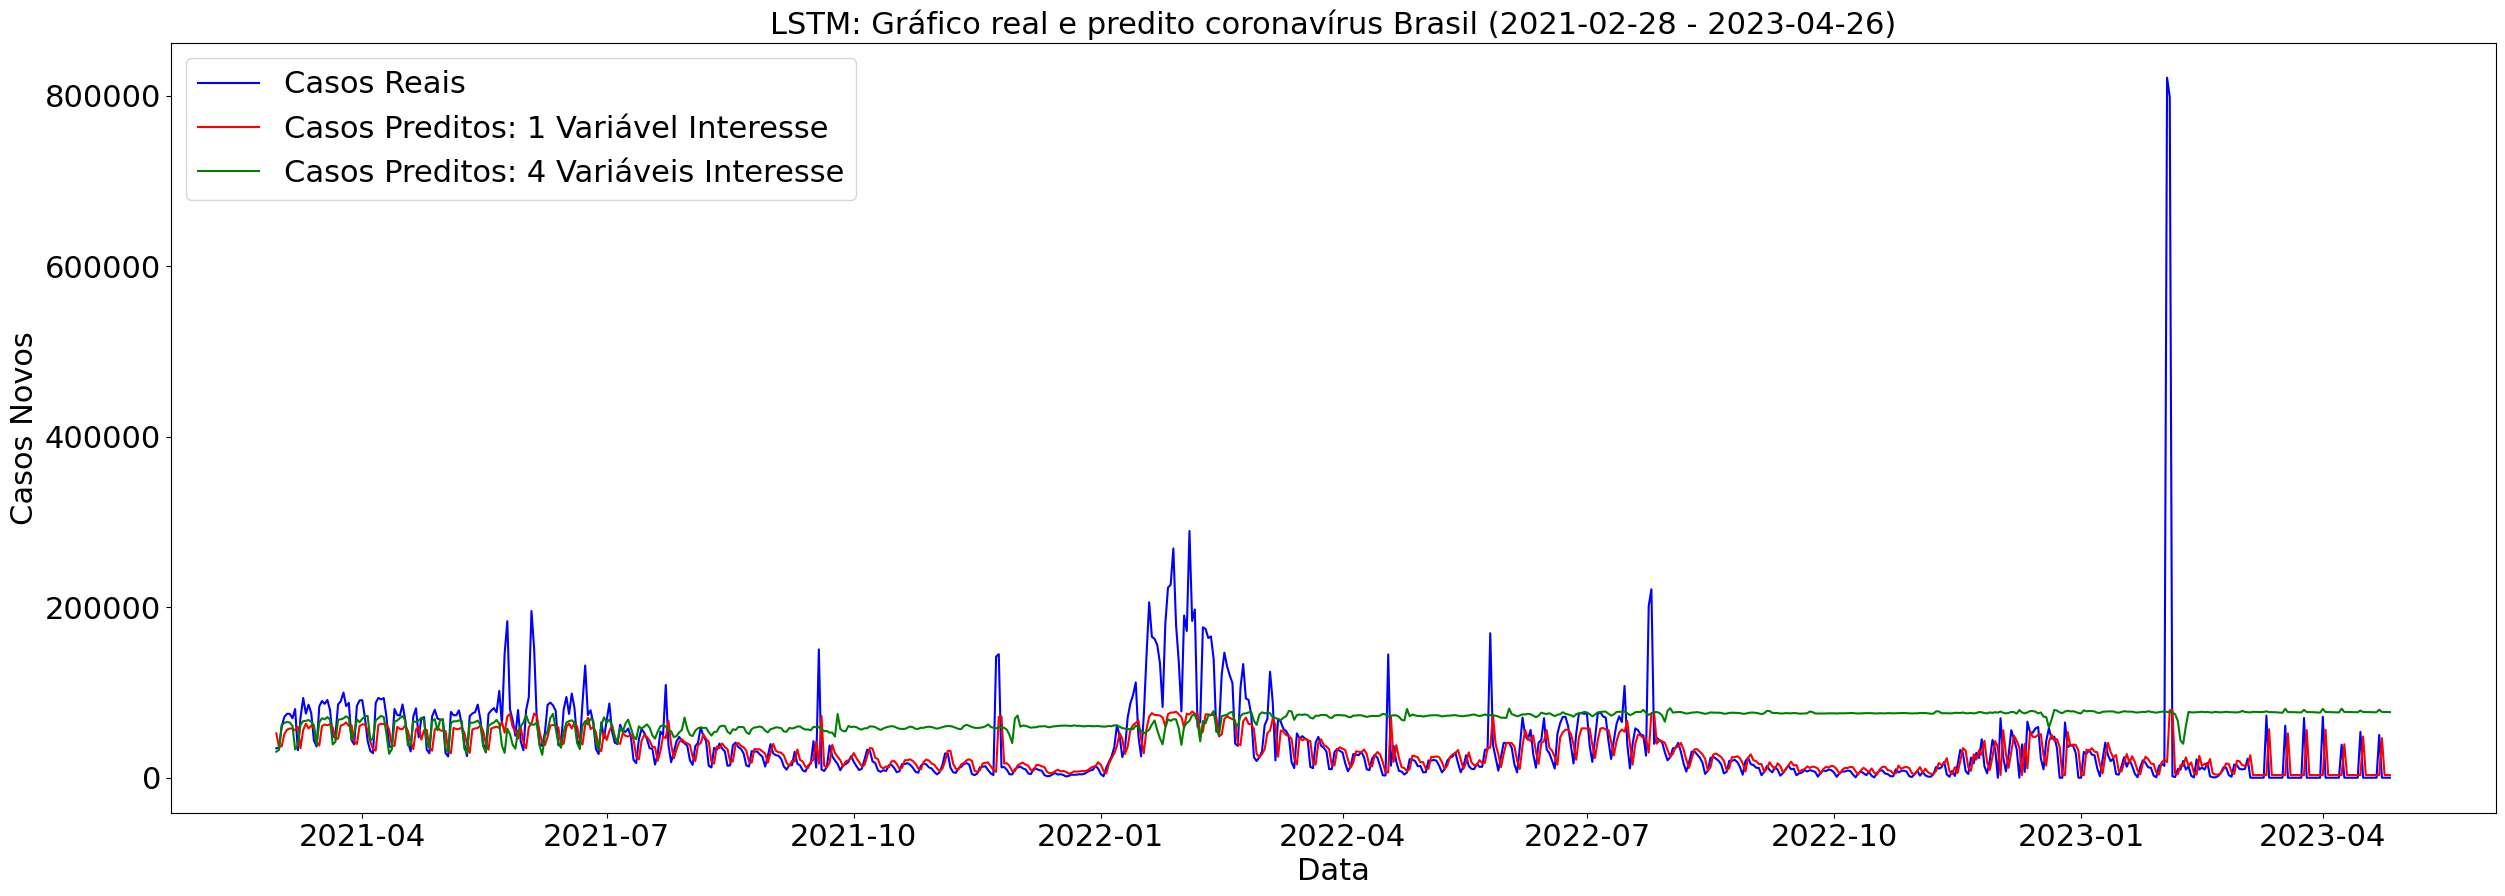

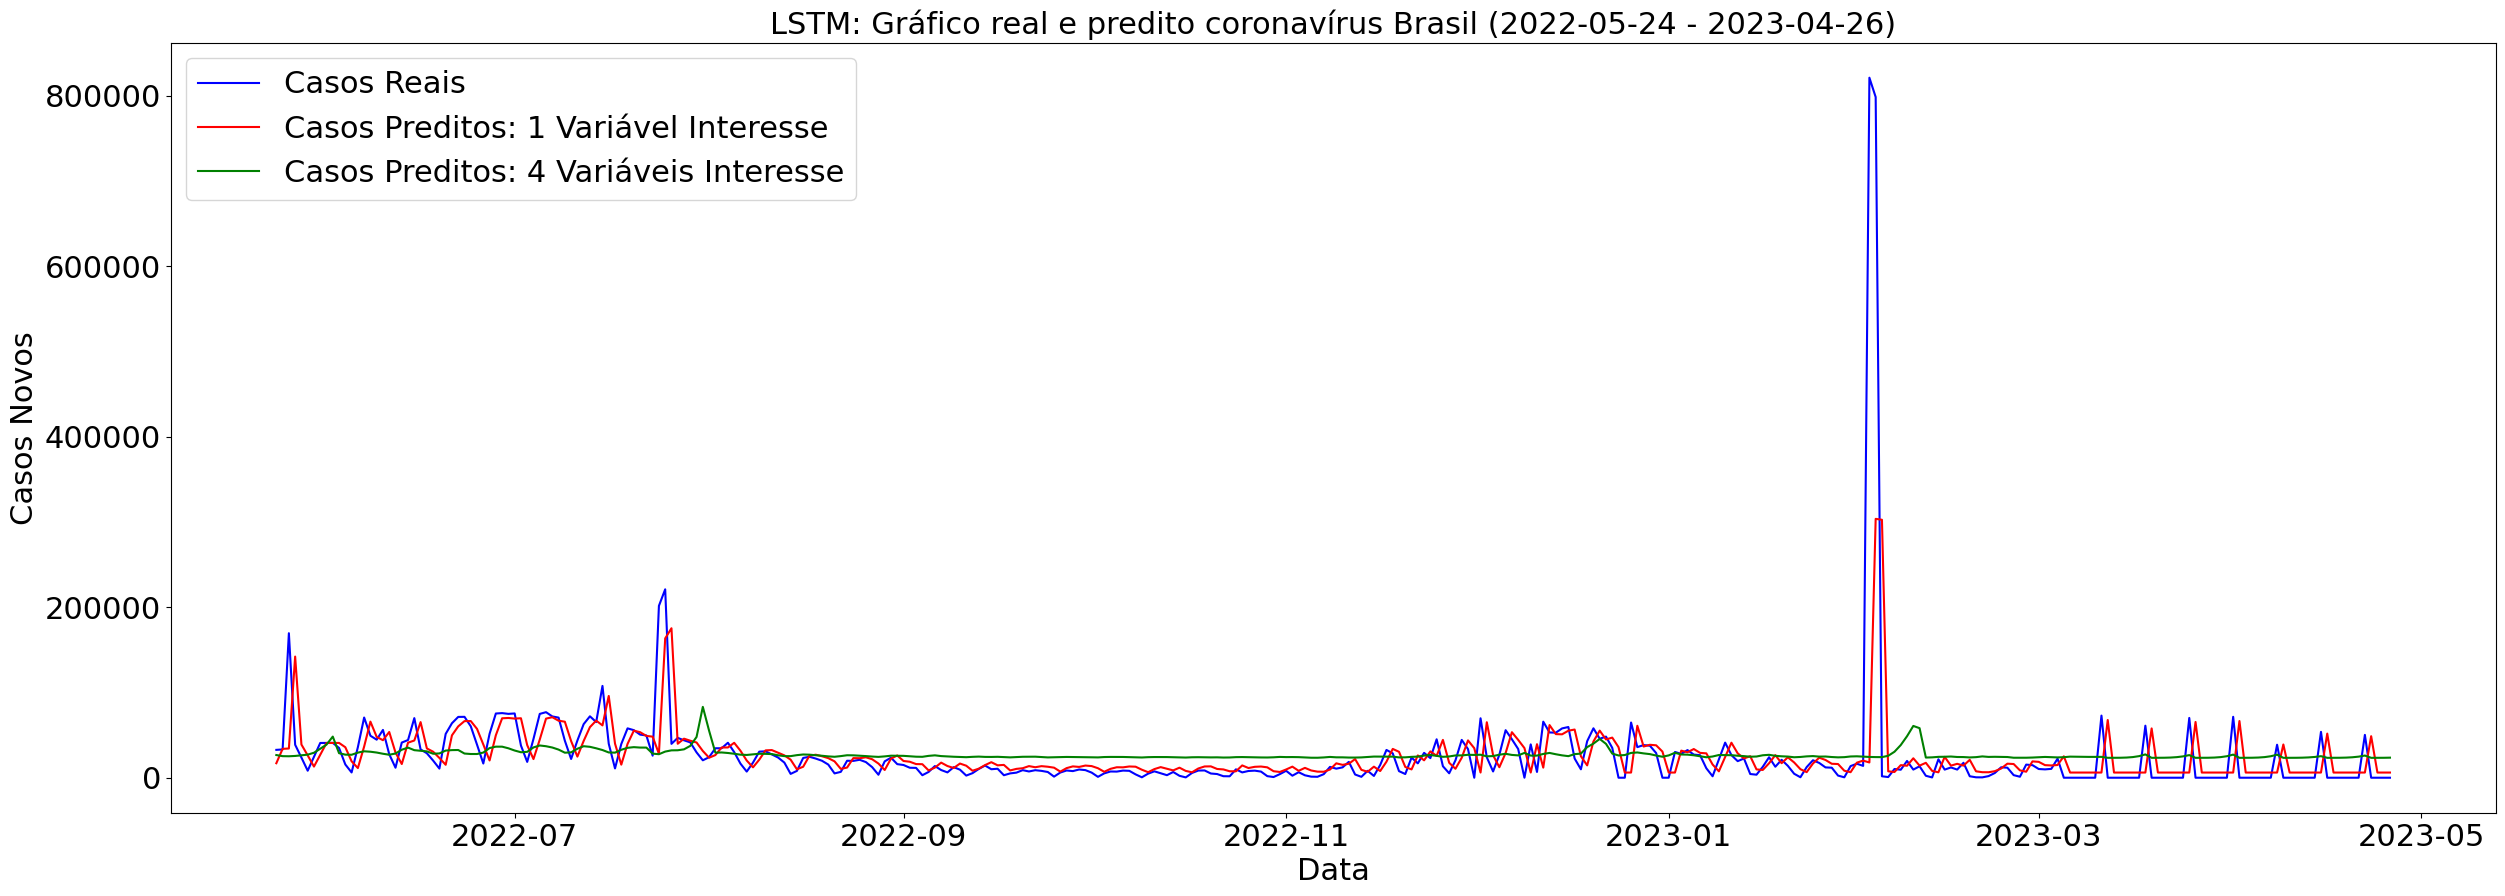

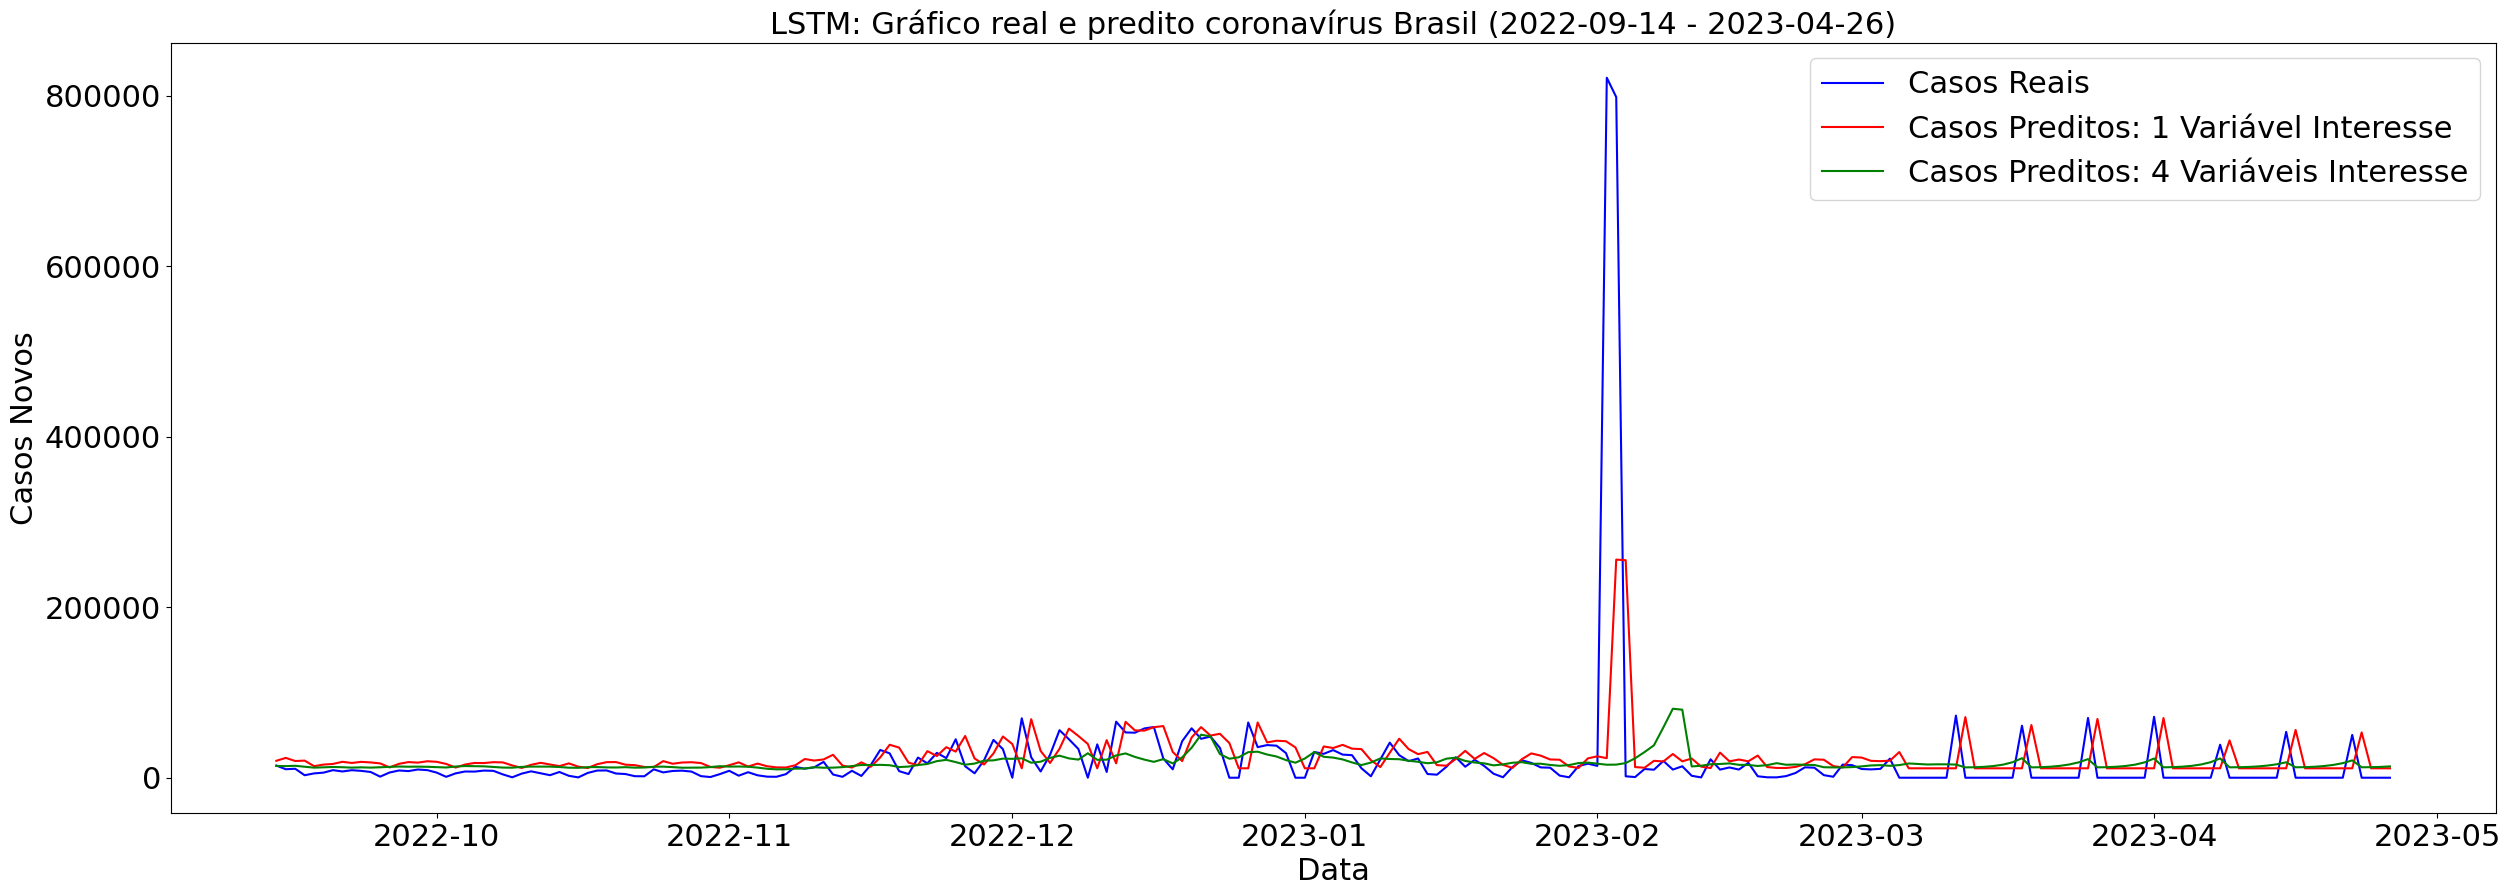

In [8]:
# Desabilitar a saída
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Separando a base de treino
vetor_proporcoes = [0.3, 0.7, 0.8]
vetor_string = ['30-70','70-30','80-20']

vetor_rmse_1v = []
vetor_mae_1v  = []
vetor_rmse_4v = []
vetor_mae_4v  = []

cont = 0

with open(os.devnull, "w") as f:
  for v in vetor_proporcoes:
    # Redirecionar a saída para devnull
    old_stdout = sys.stdout
    sys.stdout = f

    x_data, array_real, array_pedc_1v = lstm_1v(tabela_final,v)
    array_pedc_4v                     = lstm_4v(tabela_final,v)

    # Restaurar a saída padrão
    sys.stdout = old_stdout

    data1 = str(x_data[0]).replace('[\'','').split('T')
    data2 = str(x_data[len(x_data)-1]).replace('[\'','').split('T')

    plt.rcParams['xtick.labelsize'] = 22
    plt.rcParams['ytick.labelsize'] = 22

    plt.figure(figsize=(30,10))
    plt.plot(x_data,array_real, color='blue', label='Casos Reais')
    plt.plot(x_data,array_pedc_1v, color='red',  label='Casos Preditos: 1 Variável Interesse')
    plt.plot(x_data,array_pedc_4v, color='green',  label='Casos Preditos: 4 Variáveis Interesse')
    plt.title('LSTM: Gráfico real e predito coronavírus Brasil ('+ str(data1[0]) + ' - ' + str(data2[0]) + ')',fontsize=22)
    plt.xlabel('Data',fontsize=22)
    plt.ylabel('Casos Novos',fontsize=22)
    plt.legend(prop={"size":22})
    plt.savefig("img/grafico_comp_" + vetor_string[cont] + ".png")
    plt.show()

    plt.close('all')

    evaluate_performance(array_real, array_pedc_1v, vetor_rmse_1v, vetor_mae_1v)

    evaluate_performance(array_real, array_pedc_4v,vetor_rmse_4v,vetor_mae_4v)

    cont = cont + 1

In [9]:
print("rmse_1")
print(vetor_rmse_1v)
print("mae_1")
print(vetor_mae_1v)
print("rmse_4")
print(vetor_rmse_4v)
print("mae_4")
print(vetor_mae_4v)

rmse_1
[13771.267412061889, 12050.521098752506, 13024.88224676992]
mae_1
[19421.18274111675, 18455.71597633136, 22313.49777777778]
rmse_4
[14841.19531684497, 19370.29381713479, 12187.364553868441]
mae_4
[47553.831218274114, 23558.621301775147, 19144.36]
